C:\Users\TusharPatil\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Time taken by the spectral librosa function: 7.64067530632019 seconds
Time taken by the spectral librosa function: 3.2771835327148438 seconds
Time taken by the spectral librosa function: 3.3281097412109375 seconds
Time taken by the spectral librosa function: 7.4949047565460205 seconds
Time taken by the spectral librosa function: 7.439110994338989 seconds
Time taken by the spectral librosa function: 6.325314044952393 seconds
Time taken by the spectral librosa function: 9.293656587600708 seconds
Time taken by the spectral librosa function: 4.072181940078735 seconds
Time taken by the spectral librosa function: 7.105859994888306 seconds
Time taken by the spectral librosa function: 6.0884034633636475 seconds
Time taken by the spectral librosa function: 5.283103942871094 seconds
Time taken by the feature audio function: 3.9980201721191406 seconds
Time taken by the feature audio function: 2.11672306060791 seconds
Time taken by the feature audio function: 1.9445288181304932 seconds
Time taken 

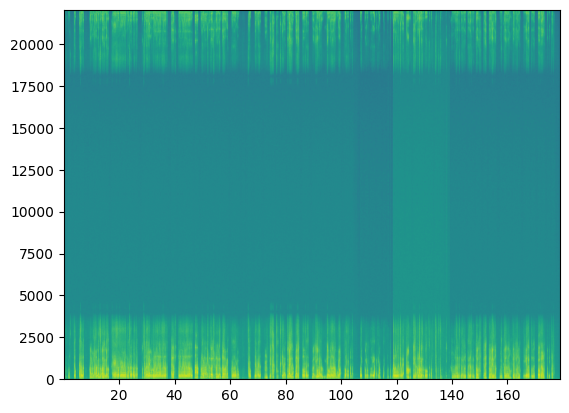

In [2]:
import pandas as pd
import numpy as np
import os
import glob
from dataclasses import dataclass
import pandas as pd
import numpy as np
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt
from scipy import stats
from dask.delayed import delayed
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
import numba
import pickle

def file_processing(folder_path: str) -> pd.DataFrame:
    path = folder_path
    list_file_name = []
    list_file_path = []
    # loop over the list of wav files
    for filename in glob.glob(os.path.join(path, '*.wav')):
        list_file_path.append(filename)
        list_file_name.append(os.path.basename(filename))
    df = pd.DataFrame(zip(list_file_name, list_file_path), columns=['Audio_File_Name', 'Audio_File_Path'])
    return df

@numba.jit
def extract_audio_spectral_librosa(row):
    start_time = time.time()
    frame_length = 1024
    hop_length = 512
    threshold = 0.01
    fade_in_duration_ms = 1000
    fade_out_duration_ms = 1000
    y, sr = librosa.load(row['Audio_File_Path']) 
    
    row['average_amplitude'] = np.mean(np.abs(y))
    row['fade_out_duration_ms'] = fade_out_duration_ms
    row['fade_in_duration_ms'] = fade_in_duration_ms
    row['fade_in_out_duration_ms'] = fade_in_duration_ms + fade_out_duration_ms
    row['fade_out_duration_seconds'] = np.mean(fade_out_duration_ms / 1000.0)
    row['fade_in_out_duration_seconds'] = np.mean((fade_in_duration_ms + fade_out_duration_ms) / 1000.0)
    
    
    
    row['chroma_stft_mean'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    row['zero_crossing_rate_mean'] = np.mean(np.array(librosa.feature.zero_crossing_rate(y)))
    row['mfccs_mean'] = np.mean(librosa.feature.mfcc(y=y, sr=sr))
    row['spectral_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    row['spectral_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    row['spectral_contrast_mean']= np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    row['spectral_rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    row['zero_crossings'] = np.mean(librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length))
    row['energy'] = np.mean(librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length, center=True))
#     row['unvoiced_mask']= (row['zero_crossings'] < threshold) & (row['energy'] < threshold)
#     row['degree_of_unvoiceness'] = np.mean(row['unvoiced_mask'])
    end_time = time.time()
    print(f"Time taken by the spectral librosa function: {end_time - start_time} seconds")
    return row

@numba.jit
def features_on_audio_segment(row):
    start_time = time.time()
    audio = AudioSegment.from_file(row['Audio_File_Path'])
    audio = audio.fade_in(1000).fade_out(1000)
    samples = audio.get_array_of_samples()
    len_audio = len(audio)
    row['duration_seconds'] = len_audio / 1000.0,
    row['duration_ms'] = len_audio
    row['frame_count'] = len_audio
    row['sample_count'] = len_audio
    row['Duration'] = len(audio)
    row['max_amplitude'] = max(audio.get_array_of_samples()),
    row['min_amplitude'] = min(audio.get_array_of_samples()),
    row['sample_rate'] = audio.frame_rate
    songspec, freqs, _, _ = plt.specgram(samples, Fs=row['sample_rate'], NFFT=2048, noverlap=1024, cmap=None)
    row['Mean Frequency'] = np.mean(songspec, axis=1)
    row['Standard Deviation'] = np.mean(np.std(songspec, axis=1))
    row['Median'] = np.mean(np.median(songspec, axis=1))
    row['Q25'] = np.mean(np.percentile(songspec, 25, axis=1))
    row['Q75'] = np.mean(np.percentile(songspec, 75, axis=1))
    row['IQR'] = np.mean(row['Q75'] - row['Q25'])
    row['Skewness'] = np.mean(stats.skew(songspec, axis=1))
    row['Kurtosis'] = np.mean(stats.kurtosis(songspec, axis=1))
    row['Spectral Entropy'] = np.mean(-np.sum(songspec * np.log(songspec + np.finfo(float).eps), axis=1))
    row['Spectral Flatness'] = np.mean(np.exp(np.mean(np.log(songspec + np.finfo(float).eps), axis=1)))
    row['Mode'] = np.mean(np.argmax(songspec, axis=1))
    row['Centroid'] = np.mean(np.sum(freqs * np.sum(songspec, axis=1) / np.sum(np.sum(songspec, axis=1))))
    end_time = time.time()
    print(f"Time taken by the feature audio function: {end_time - start_time} seconds")
    return row

df = file_processing(r"C:\Users\TusharPatil\Desktop\Audio Analysis\normal")
df = df.apply(extract_audio_spectral_librosa, axis=1)
df = df.apply(features_on_audio_segment, axis=1)

# Loading the model
file = open(r"C:\Users\TusharPatil\PycharmProjects\pythonProject\Linear_Discriminant_Analysis.pkl", 'rb')
model = pickle.load(file)

# Defining the scaler
scaler = StandardScaler()

# Predicting and saving results
X = df.drop(['Audio_File_Name', 'Audio_File_Path'], axis=1)
X = X.select_dtypes(include=[np.number])
X = scaler.fit_transform(X)
y_predict = model.predict(X)
class_labels = ['background_noise', 'blank_call', 'echo', 'low_volume', 'normal']
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)
encoded_labels = label_encoder.inverse_transform(y_predict)

# Creating a new DataFrame with results
df2 = pd.DataFrame({
    'Audio_File_Name': df['Audio_File_Name'],
    'Audio_File_Path': df['Audio_File_Path'],
    'encoded_labels': encoded_labels
})

# Saving the DataFrame to an Excel file
df2.to_excel(r"C:\Users\TusharPatil\Documents\output_excel.xlsx")


In [3]:
from multiprocessing import Pool

def process_row_librosa(row):
    return extract_audio_spectral_librosa(row)

def process_row_audio_segment(row):
    return features_on_audio_segment(row)

if __name__ == '__main__':
    # Using Pool for parallel processing
    with Pool(5) as p:
        df = file_processing(r"C:\Users\TusharPatil\Desktop\Audio Analysis\normal")

        # Apply extract_audio_spectral_librosa function in parallel
        df_librosa_list = (p.map(process_row_librosa, df.itertuples(index=False), chunksize=100))
        df_librosa = pd.concat(df_librosa_list)

        # Apply features_on_audio_segment function in parallel
        df_audio_segment_list = (p.map(process_row_audio_segment, df.itertuples(index=False), chunksize=100))
        df_audio_segment = pd.concat(df_audio_segment_list)


PicklingError: Can't pickle <class 'pandas.core.frame.Pandas'>: attribute lookup Pandas on pandas.core.frame failed